# Testing the single-lineage hierarchical negative binomial GLM

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from time import time

import aesara  # noqa: F401
import arviz as az
import janitor  # noqa: F401
import jax  # noqa: F401
import jaxlib  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.sampling_jax

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:88: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.


In [3]:
from speclet.analysis import arviz_analysis as az_ana
from speclet.io import DataFile
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import scale_fill_heatmap, set_theme_speclet
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_theme_speclet()
%config InlineBackend.figure_format = "retina"

# Constants
SEED = 847
arviz_config()

## Data

In [5]:
crispr_dm = CrisprScreenDataManager(data_file=DataFile.DEPMAP_CRC_SUBSAMPLE)
crc_crispr_data = (
    crispr_dm.get_data()
    .query("lineage == 'colorectal'")
    .query("screen == 'broad'")
    .reset_index(drop=True)
)
crc_crispr_data.head()

sgrna                    replicate_id       lfc p_dna_batch  \
0  CGGAGCCTCGCCATTCCCGA  COLO201-311Cas9_RepA_p6_batch3 -0.183298           3   
1  AAATAATTAAGTATGCACAT  COLO201-311Cas9_RepA_p6_batch3 -1.102995           3   
2  AACAGCTGTTTACCAAGCGA  COLO201-311Cas9_RepA_p6_batch3 -0.991020           3   
3  AATCAACCCACAGCTGCACA  COLO201-311Cas9_RepA_p6_batch3  0.219207           3   
4  ACAAGGGGCGACCGTCGCCA  COLO201-311Cas9_RepA_p6_batch3  0.003980           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr9_136410332_-       ENTR1  broad                   True   
1  chr13_48081696_-        MED4  broad                   True   
2  chr13_48083409_-        MED4  broad                   True   
3   chr17_7675183_+        TP53  broad                   True   
4  chr8_103415011_-      DCAF13  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                9         136410332  ...             NaN               NaN   
1               13          48081696  ...             NaN               NaN   
2               13          48083409  ...             NaN               NaN   
3               17           7675183  ...             NaN               NaN   
4                8         103415011  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number     lineage  \
0                 NaN       False     1.064776  colorectal   
1                 NaN       False     1.582238  colorectal   
2                 NaN       False     1.582238  colorectal   
3                 NaN       False     0.978003  colorectal   
4                 NaN       False     1.234548  colorectal   

             lineage_subtype primary_or_metastasis  is_male   age  
0  colorectal_adenocarcinoma            metastasis     True  70.0  
1  colorectal_adenocarcinoma            metastasis     True  70.0  
2  colorectal_adenocarcinoma            metastasis     True  70.0  
3  colorectal_adenocarcinoma            metastasis     True  70.0  
4  colorectal_adenocarcinoma            metastasis     True  70.0  

[5 rows x 25 columns]

In [6]:
for col in ["sgrna", "hugo_symbol", "depmap_id"]:
    n = crc_crispr_data[col].nunique()
    print(f"{col}: {n}")

sgrna: 162
hugo_symbol: 103
depmap_id: 8


## Model object

In [19]:
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel

In [20]:
crc_hnb = LineageHierNegBinomModel(lineage="colorectal")

### Data inspection

In [21]:
model_data = crc_hnb.make_data_structure(
    crc_hnb.data_processing_pipeline(crc_crispr_data)
)

In [22]:
model_data.coords["cancer_gene"]

['FBXW7', 'KRAS', 'PIK3CA']

In [23]:
crc_crispr_data.filter_column_isin("hugo_symbol", model_data.coords["cancer_gene"])[
    ["depmap_id", "hugo_symbol", "is_mutated"]
].drop_duplicates().query("is_mutated").sort_values(["hugo_symbol", "depmap_id"])

depmap_id hugo_symbol  is_mutated
712   ACH-000470       FBXW7        True
874   ACH-000958       FBXW7        True
1036  ACH-001786       FBXW7        True
173   ACH-000286        KRAS        True
497   ACH-000350        KRAS        True
659   ACH-000470        KRAS        True
1145  ACH-002024        KRAS        True
961   ACH-000958      PIK3CA        True
1123  ACH-001786      PIK3CA        True
1285  ACH-002024      PIK3CA        True

In [24]:
pd.DataFrame(
    model_data.comutation_matrix, columns=model_data.coords["cell_line"]
).assign(cancer_gene=model_data.coords["cancer_gene"]).set_index("cancer_gene")

ACH-000253  ACH-000286  ACH-000296  ACH-000350  ACH-000470  \
cancer_gene                                                               
FBXW7                 0           0           0           0           1   
KRAS                  0           1           0           1           1   
PIK3CA                0           0           0           0           0   

             ACH-000958  ACH-001786  ACH-002024  
cancer_gene                                      
FBXW7                 1           1           0  
KRAS                  0           0           1  
PIK3CA                1           1           1

In [25]:
processed_crc_crispr_data = crc_hnb.data_processing_pipeline(crc_crispr_data.copy())
processed_crc_crispr_data

sgrna                    replicate_id       lfc  \
0     CGGAGCCTCGCCATTCCCGA  COLO201-311Cas9_RepA_p6_batch3 -0.183298   
1     AAATAATTAAGTATGCACAT  COLO201-311Cas9_RepA_p6_batch3 -1.102995   
2     AACAGCTGTTTACCAAGCGA  COLO201-311Cas9_RepA_p6_batch3 -0.991020   
3     AATCAACCCACAGCTGCACA  COLO201-311Cas9_RepA_p6_batch3  0.219207   
4     ACAAGGGGCGACCGTCGCCA  COLO201-311Cas9_RepA_p6_batch3  0.003980   
...                    ...                             ...       ...   
1291  TTGCCGGCAAAACTACGGAG     ECC4-311Cas9-RepA-p6_batch4  0.176213   
1292  TTGCGGGTAGAGGAAAAAAC     ECC4-311Cas9-RepA-p6_batch4  0.110373   
1293  TTTCGGGTAGATCATGCGCA     ECC4-311Cas9-RepA-p6_batch4 -0.721768   
1294  TTTGCCATCTTGCAGTACAG     ECC4-311Cas9-RepA-p6_batch4 -0.051578   
1295  TTTGGGACAGGAGGAACAAG     ECC4-311Cas9-RepA-p6_batch4 -0.179139   

     p_dna_batch  genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0              3  chr9_136410332_-       ENTR1  broad                   True   
1              3  chr13_48081696_-        MED4  broad                   True   
2              3  chr13_48083409_-        MED4  broad                   True   
3              3   chr17_7675183_+        TP53  broad                   True   
4              3  chr8_103415011_-      DCAF13  broad                   True   
...          ...               ...         ...    ...                    ...   
1291           4  chr8_103415288_+      DCAF13  broad                   True   
1292           4  chr12_72273400_-       TRHDE  broad                   True   
1293           4  chr1_169862790_-       SCYL3  broad                   True   
1294           4  chr1_169888752_+       SCYL3  broad                   True   
1295           4   chr9_92108792_+      SPTLC1  broad                   True   

     sgrna_target_chr  sgrna_target_pos  ... is_male   age  z_rna_gene  \
0                   9         136410332  ...    True  70.0   -1.029051   
1                  13          48081696  ...    True  70.0    1.022384   
2                  13          48083409  ...    True  70.0    1.022384   
3                  17           7675183  ...    True  70.0   -0.119923   
4                   8         103415011  ...    True  70.0    0.517383   
...               ...               ...  ...     ...   ...         ...   
1291                8         103415288  ...    True  45.0    0.993009   
1292               12          72273400  ...    True  45.0   -0.585101   
1293                1         169862790  ...    True  45.0   -0.731159   
1294                1         169888752  ...    True  45.0   -0.731159   
1295                9          92108792  ...    True  45.0    1.921755   

      z_cn_gene  z_cn_cell_line log_rna_expr counts_final_total  \
0      0.024707        0.140881     1.773249           25199342   
1      1.391221        2.362399     2.031468           25199342   
2      1.391221        2.362399     2.031468           25199342   
3      0.412362       -0.231643     1.834365           25199342   
4      0.486485        0.869730     1.993148           25199342   
...         ...             ...          ...                ...   
1291  -0.124669        0.428913     2.035611           38332915   
1292  -2.163314       -0.928528     0.014253           38332915   
1293   0.423819        0.537961     1.193516           38332915   
1294   0.423819        0.537961     1.193516           38332915   
1295   1.058694        0.348458     2.015582           38332915   

     counts_initial_total  counts_final_rpm  counts_initial_adj  
0            1.071751e+06         23.302170          539.300191  
1            1.071751e+06         14.254314          647.495951  
2            1.071751e+06          4.928674          205.154369  
3            1.071751e+06         33.143696          576.280879  
4            1.071751e+06          6.238232          129.606944  
...                   ...               ...                 ...  
1291         1.071078e+06          5.30

### Model inspection

[06/03/22 06:57:18] WARNING  Only 1 screen detected - ignoring ]8;id=403062;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=18494;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#353\353]8;;\
                             variable `p`.                                                   

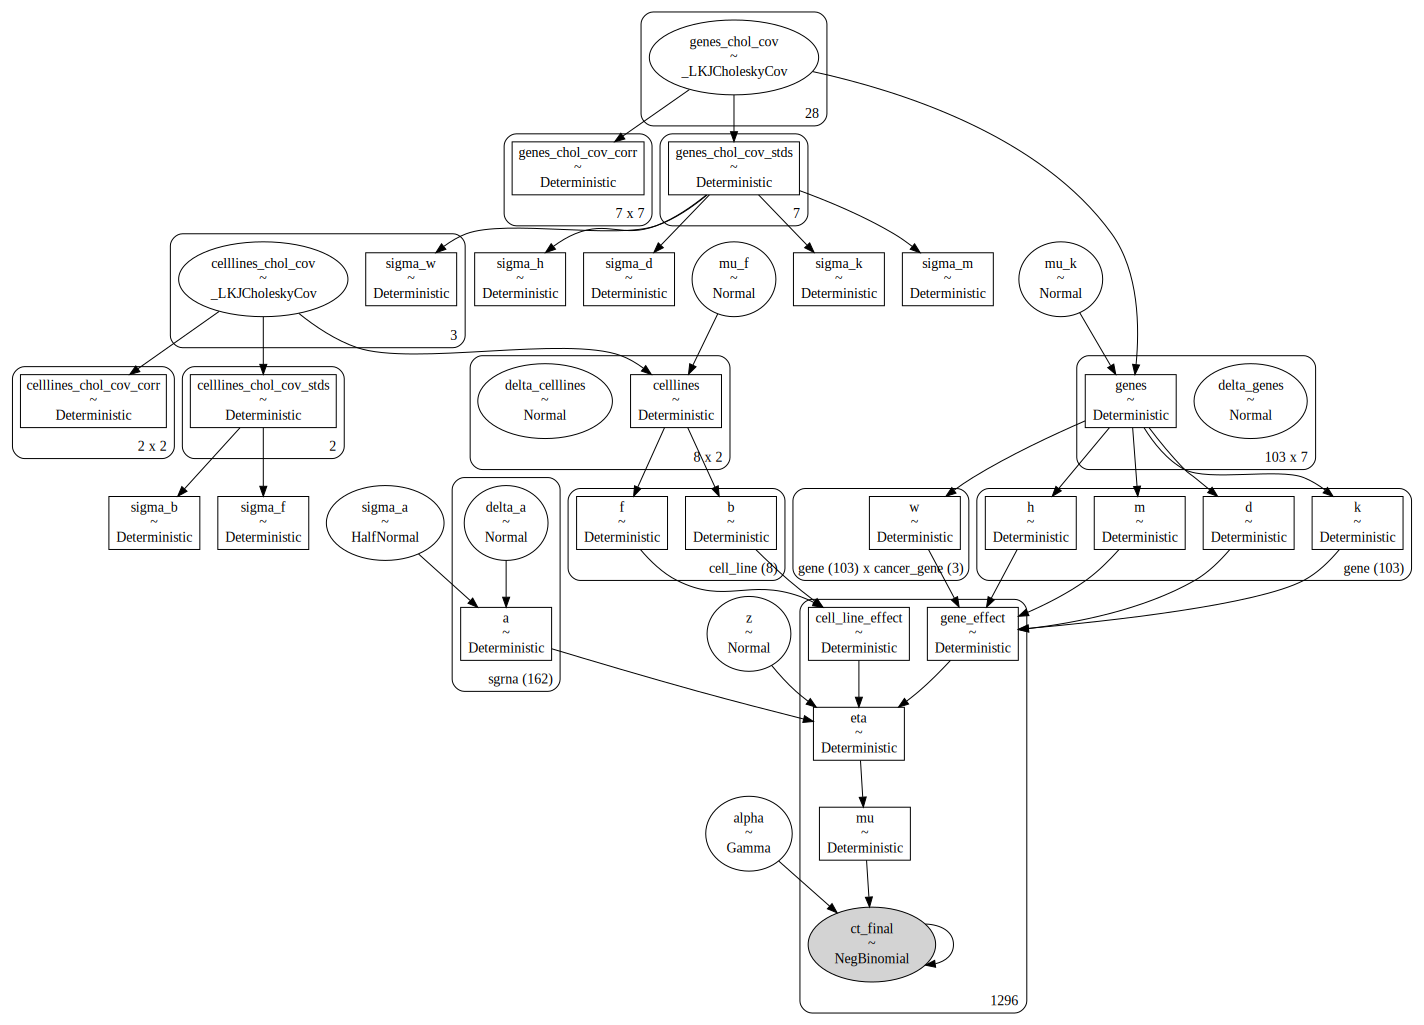

In [26]:
crc_hnb_model = crc_hnb.pymc_model(data=crc_crispr_data)
pm.model_to_graphviz(crc_hnb_model)

In [27]:
crc_hnb_model

                      z ~ N(0, 2.5)
                sigma_a ~ N**+(0, 1)
                delta_a ~ N(0, 1)
     celllines_chol_cov ~ _lkjcholeskycov(2, 2, <unnamed>)
                   mu_f ~ N(-0.5, 0.5)
        delta_celllines ~ N(0, 1)
         genes_chol_cov ~ _lkjcholeskycov(7, 2, <unnamed>)
                   mu_k ~ N(-0.5, 0.5)
            delta_genes ~ N(0, 1)
                  alpha ~ Gamma(2, f())
                      a ~ Deterministic(f(delta_a, sigma_a))
celllines_chol_cov_corr ~ Deterministic(f(celllines_chol_cov))
celllines_chol_cov_stds ~ Deterministic(f(celllines_chol_cov))
                sigma_b ~ Deterministic(f(celllines_chol_cov))
                sigma_f ~ Deterministic(f(celllines_chol_cov))
              celllines ~ Deterministic(f(mu_f, delta_celllines, celllines_chol_cov))
                      b ~ Deterministic(f(mu_f, delta_celllines, celllines_chol_cov))
                      f ~ Deterministic(f(mu_f, delta_celllines, celllines_chol_cov))
    genes_chol_cov

### Sampling

In [104]:
with crc_hnb.pymc_model(crc_crispr_data):
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        draws=500, tune=1000, target_accept=0.98, random_seed=SEED + 100
    )

[06/02/22 17:37:04] WARNING  Only 1 screen detected - ignoring ]8;id=57777;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=228741;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#384\384]8;;\
                             variable `p`.                                                   

Compiling...
Compilation time =  0:00:13.186521
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:10:02.185748
Transforming variables...
Transformation time =  0:00:08.371621


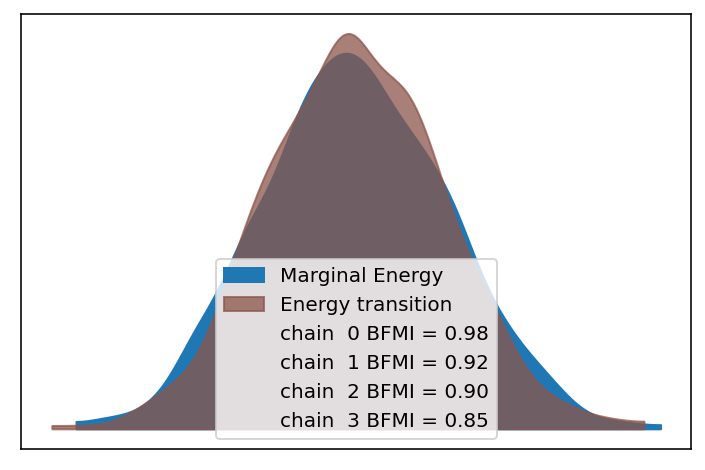

In [105]:
az.plot_energy(trace);

In [106]:
az_ana.get_divergence_summary(trace)[0]

[0, 3, 0, 0]

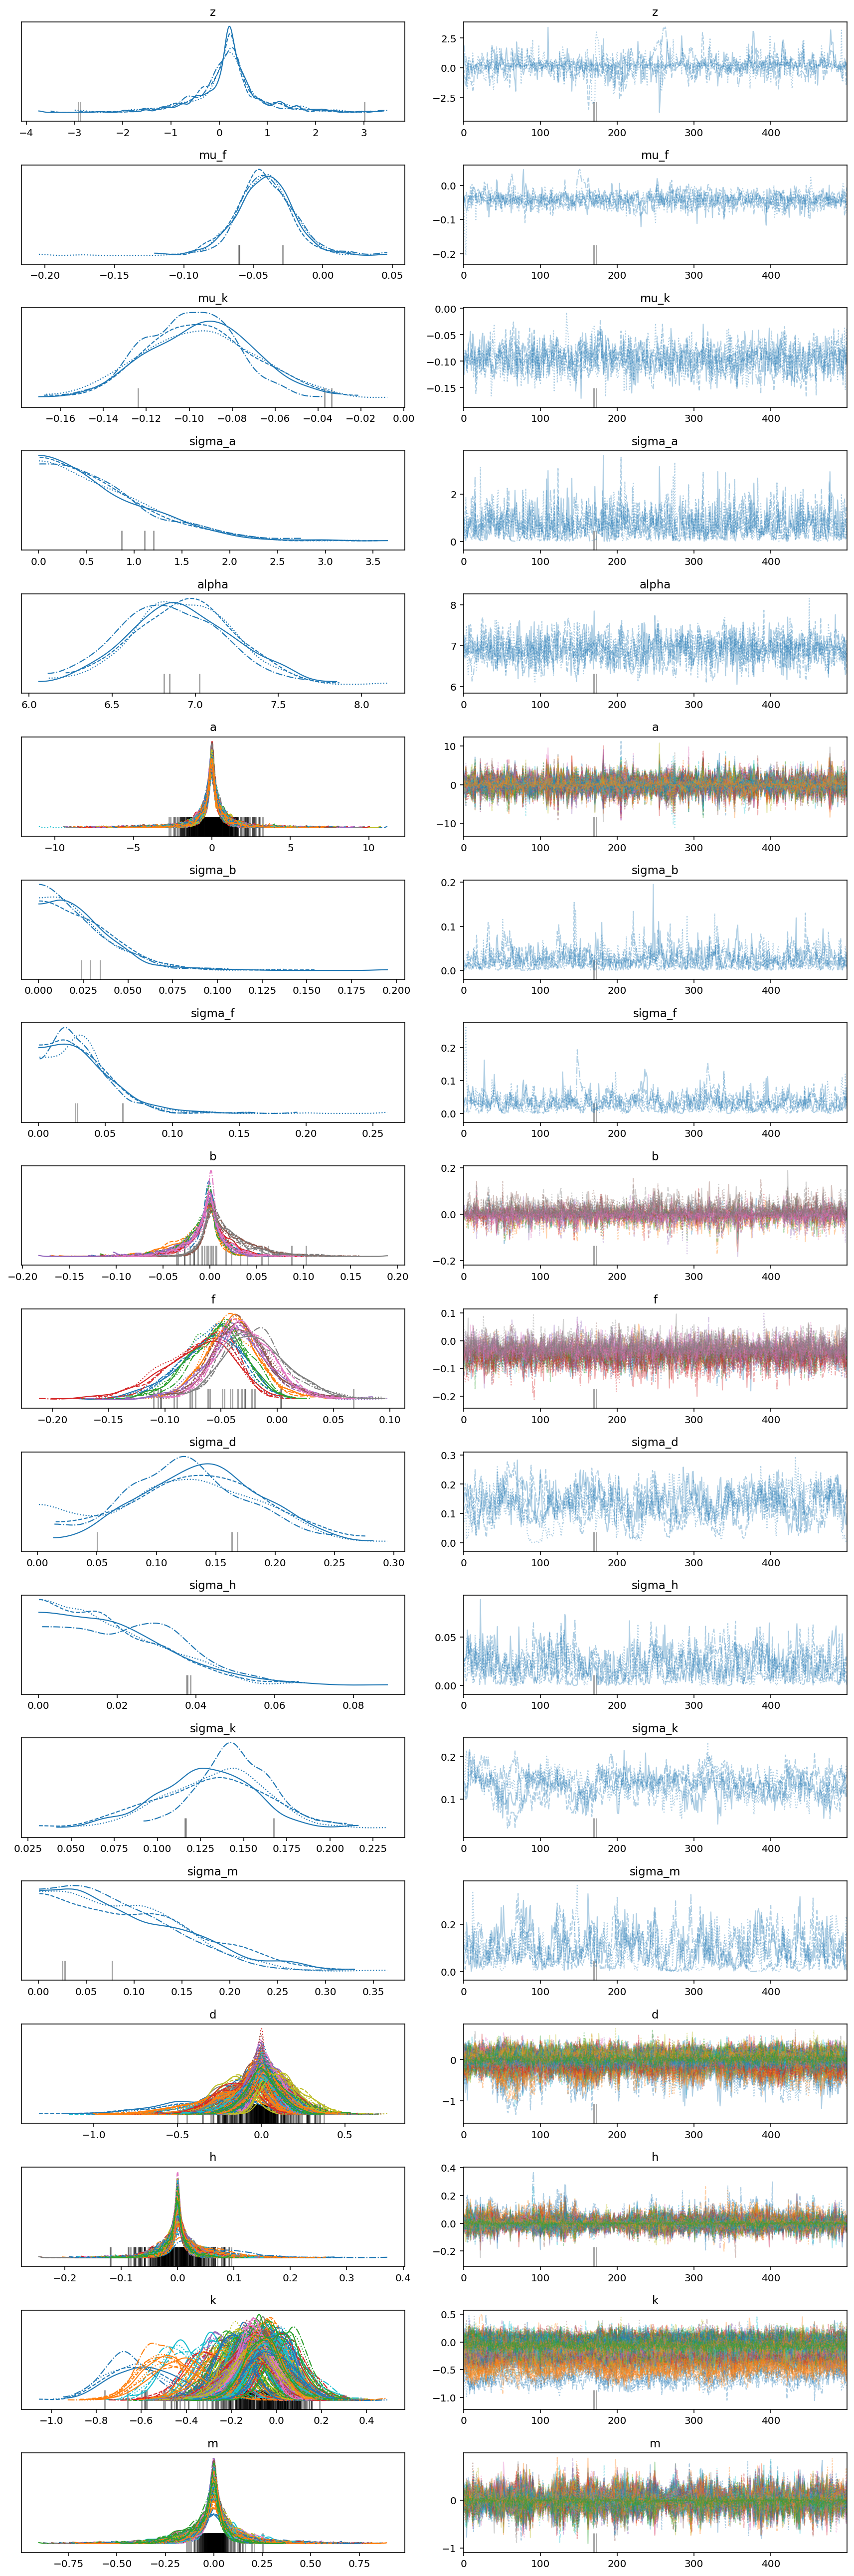

In [107]:
with az.rc_context(rc={"plot.max_subplots": 100}):
    az.plot_trace(trace, var_names=crc_hnb.vars_regex() + ["~^w$"], filter_vars="regex")
    plt.tight_layout();

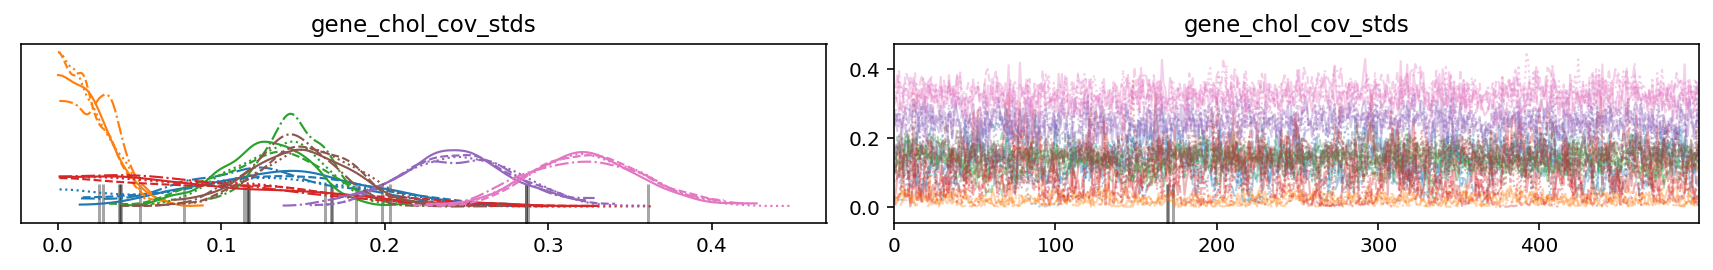

In [120]:
az.plot_trace(trace, var_names=["gene_chol_cov_stds"])
plt.tight_layout();

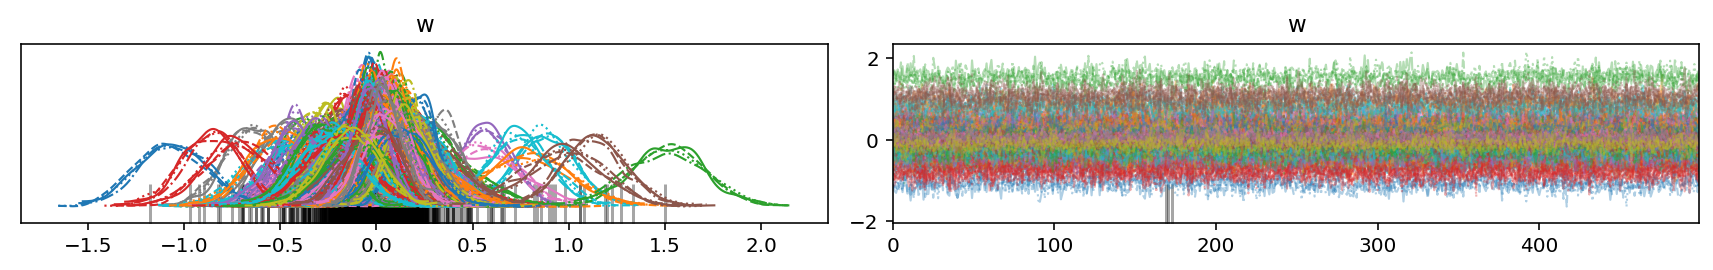

In [108]:
az.plot_trace(trace, var_names="w")
plt.tight_layout();

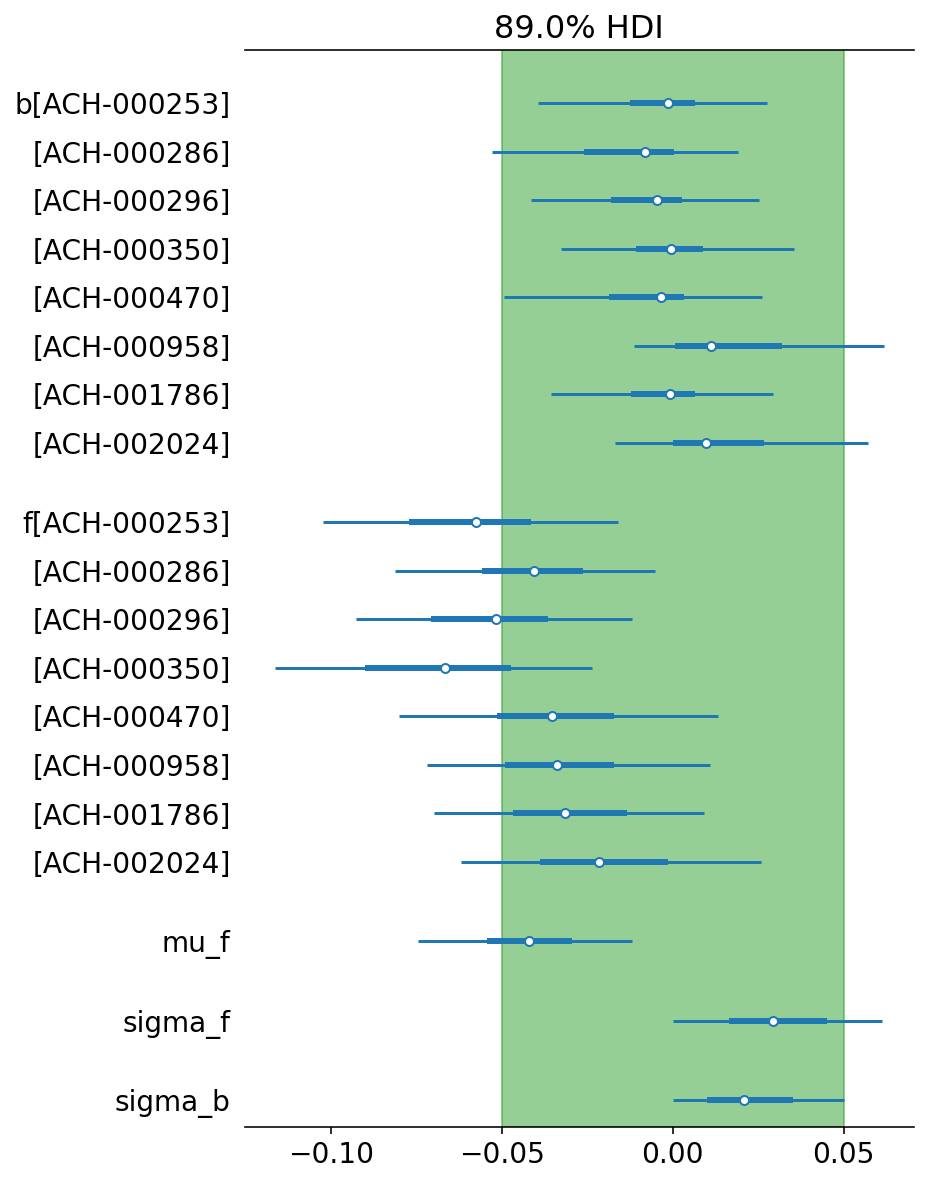

In [109]:
az.plot_forest(
    trace,
    var_names=["b", "f", "mu_f", "sigma_f", "sigma_b"],
    rope=[-0.05, 0.05],
    combined=True,
);

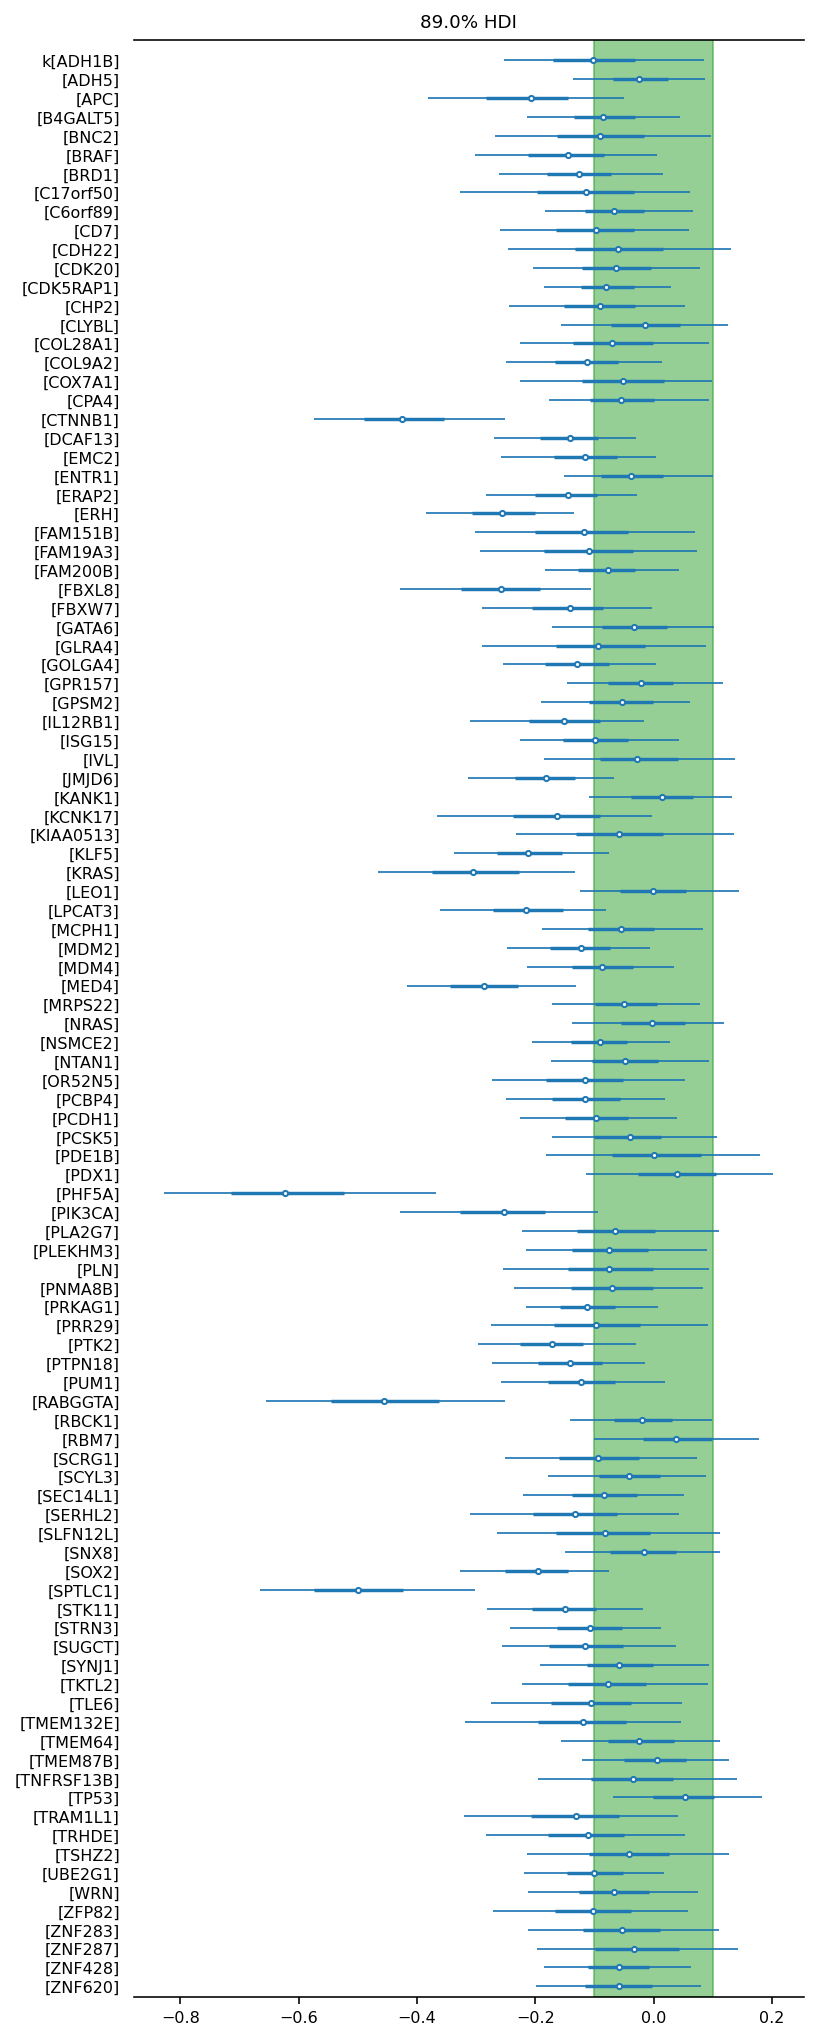

In [110]:
az.plot_forest(
    trace, var_names=["k"], combined=True, rope=[-0.1, 0.1], textsize=8, figsize=(6, 18)
);

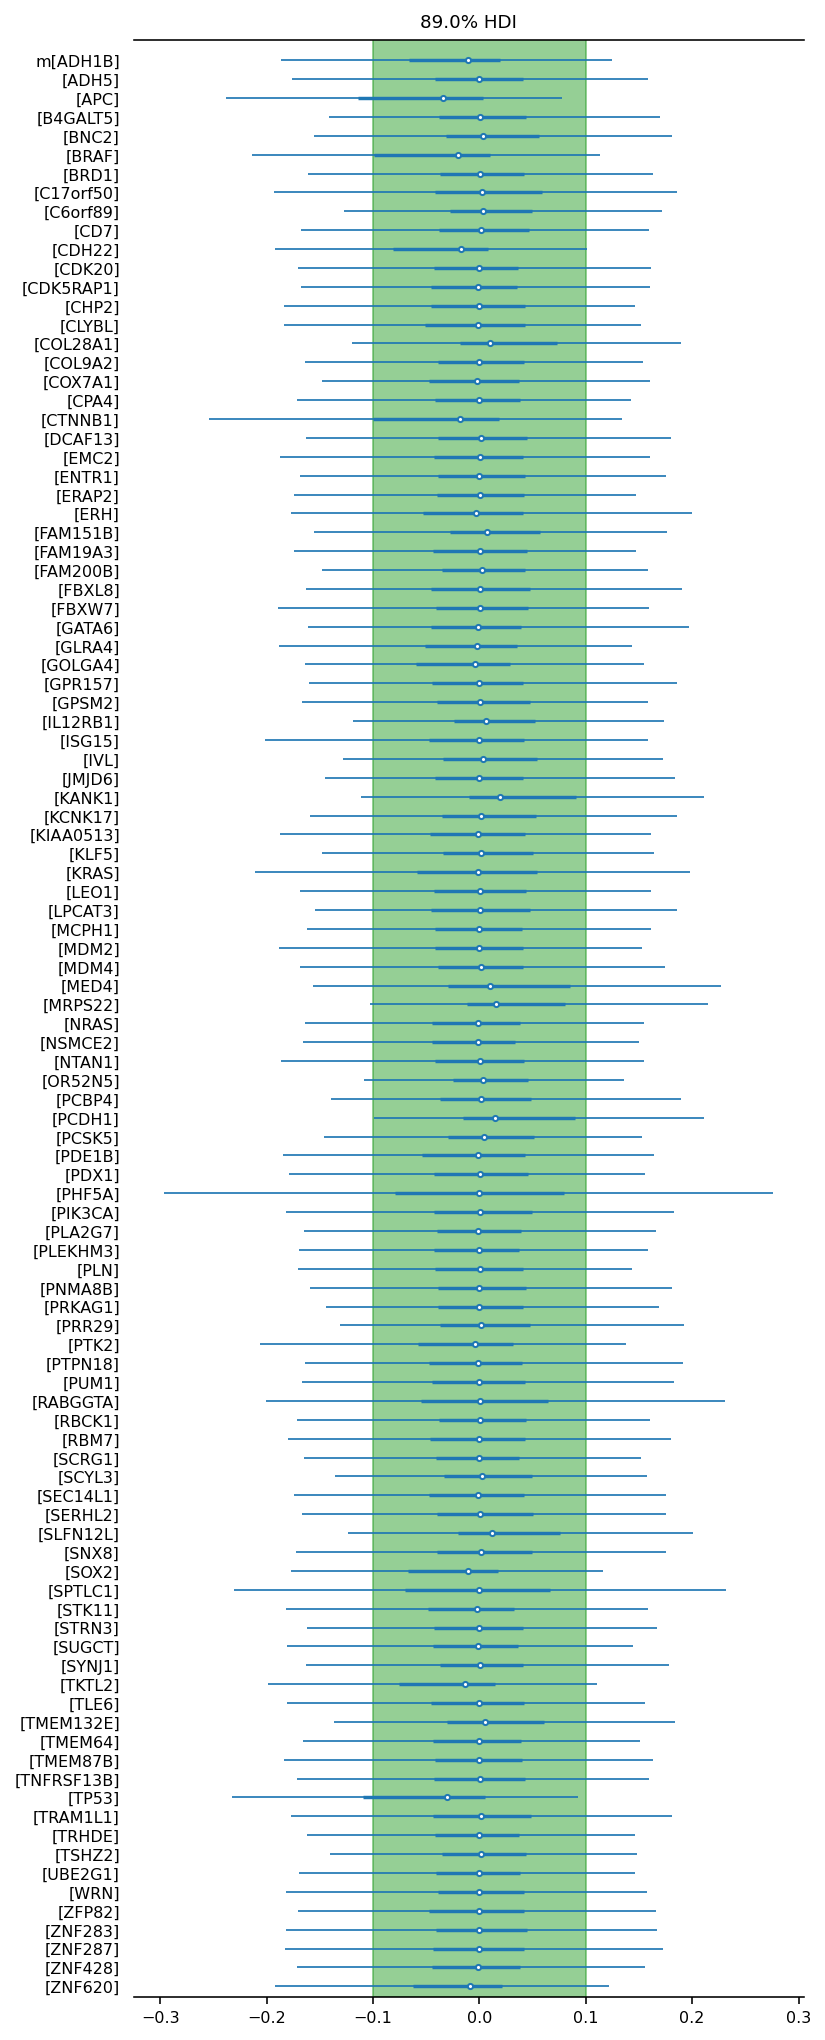

In [111]:
az.plot_forest(
    trace, var_names=["m"], combined=True, rope=[-0.1, 0.1], textsize=8, figsize=(6, 18)
);

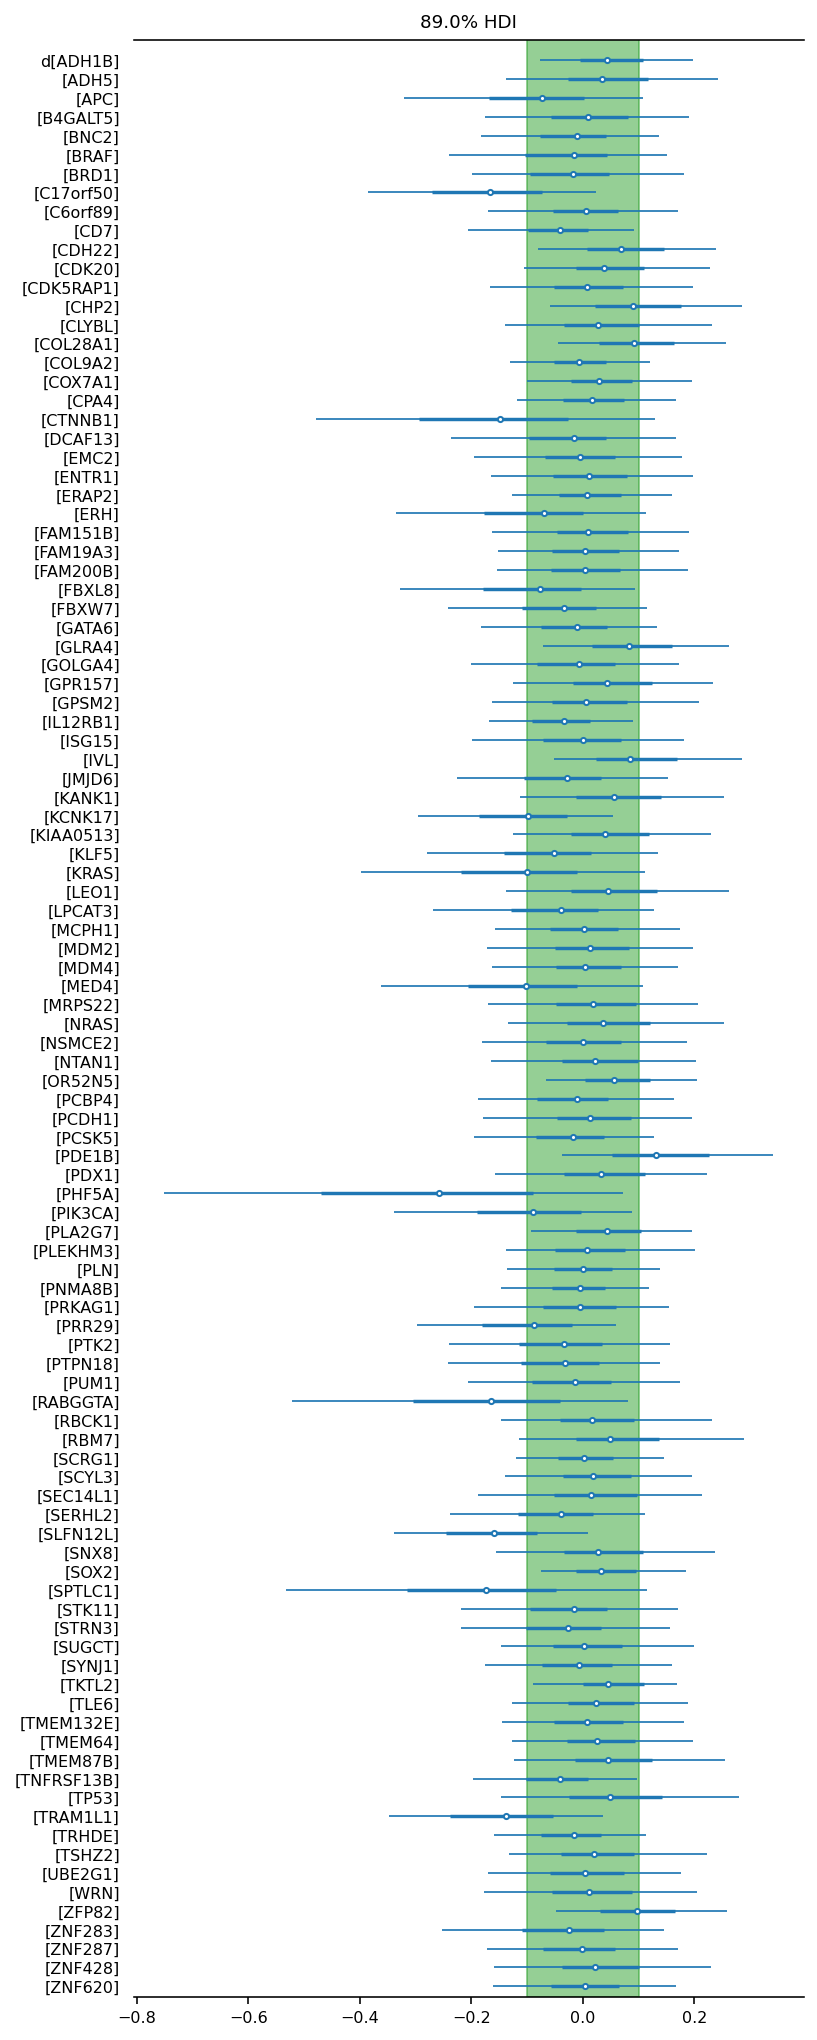

In [112]:
az.plot_forest(
    trace, var_names=["d"], combined=True, rope=[-0.1, 0.1], textsize=8, figsize=(6, 18)
);

In [113]:
gene_summary = (
    az.summary(trace, var_names=["d", "k", "h", "m"], kind="stats")
    .reset_index()
    .rename(columns={"index": "group_varname"})
    .pipe(az_ana.extract_coords_param_names, names=["hugo_symbol"], col="group_varname")
    .assign(varname=lambda d: [x.split("[")[0] for x in d["group_varname"]])
)

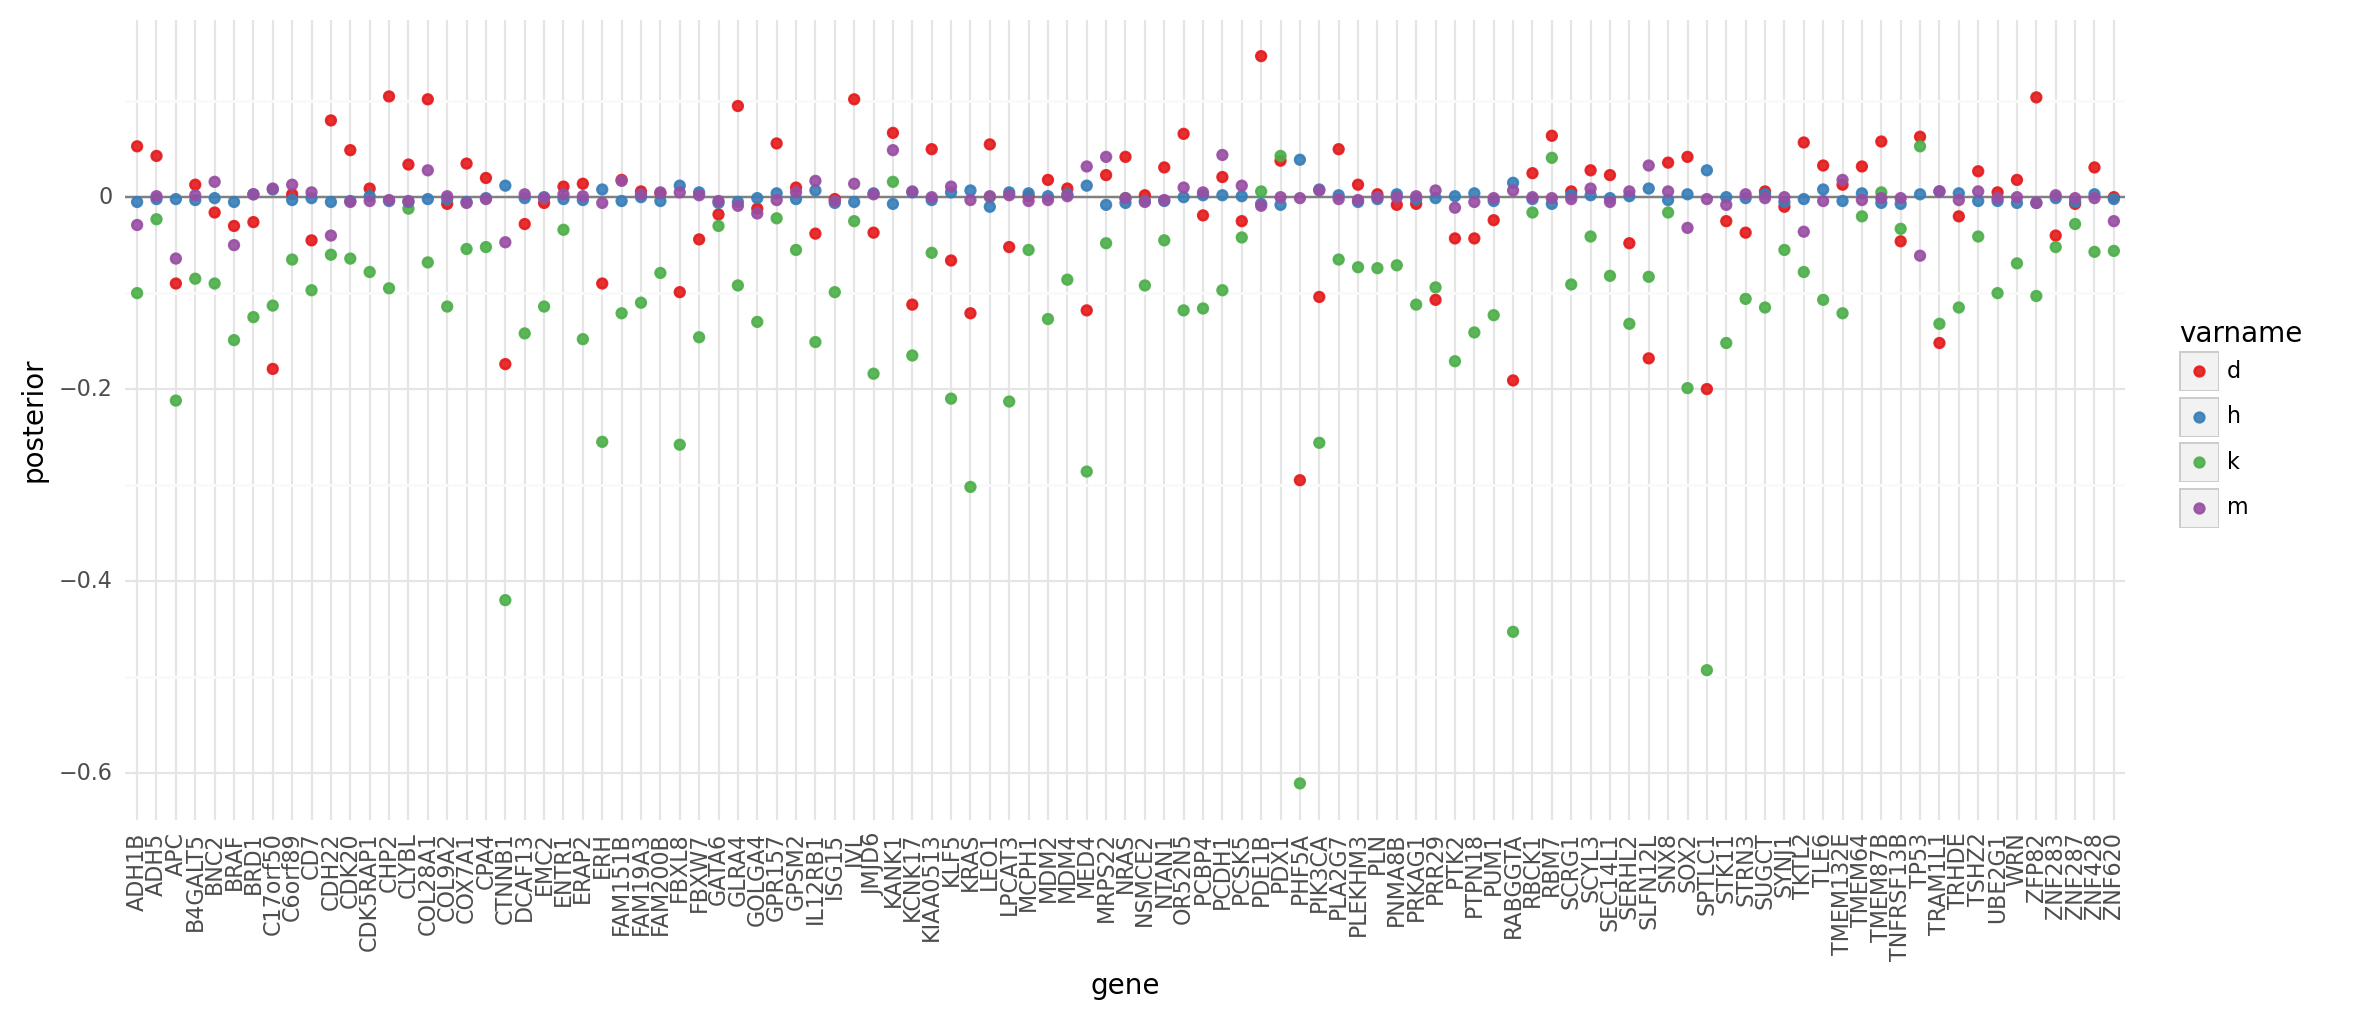

<ggplot: (365740159)>

In [114]:
(
    gg.ggplot(gene_summary, gg.aes(x="hugo_symbol", y="mean", color="varname"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_point(alpha=0.9)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=8), figure_size=(10, 4))
    + gg.labs(x="gene", y="posterior")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


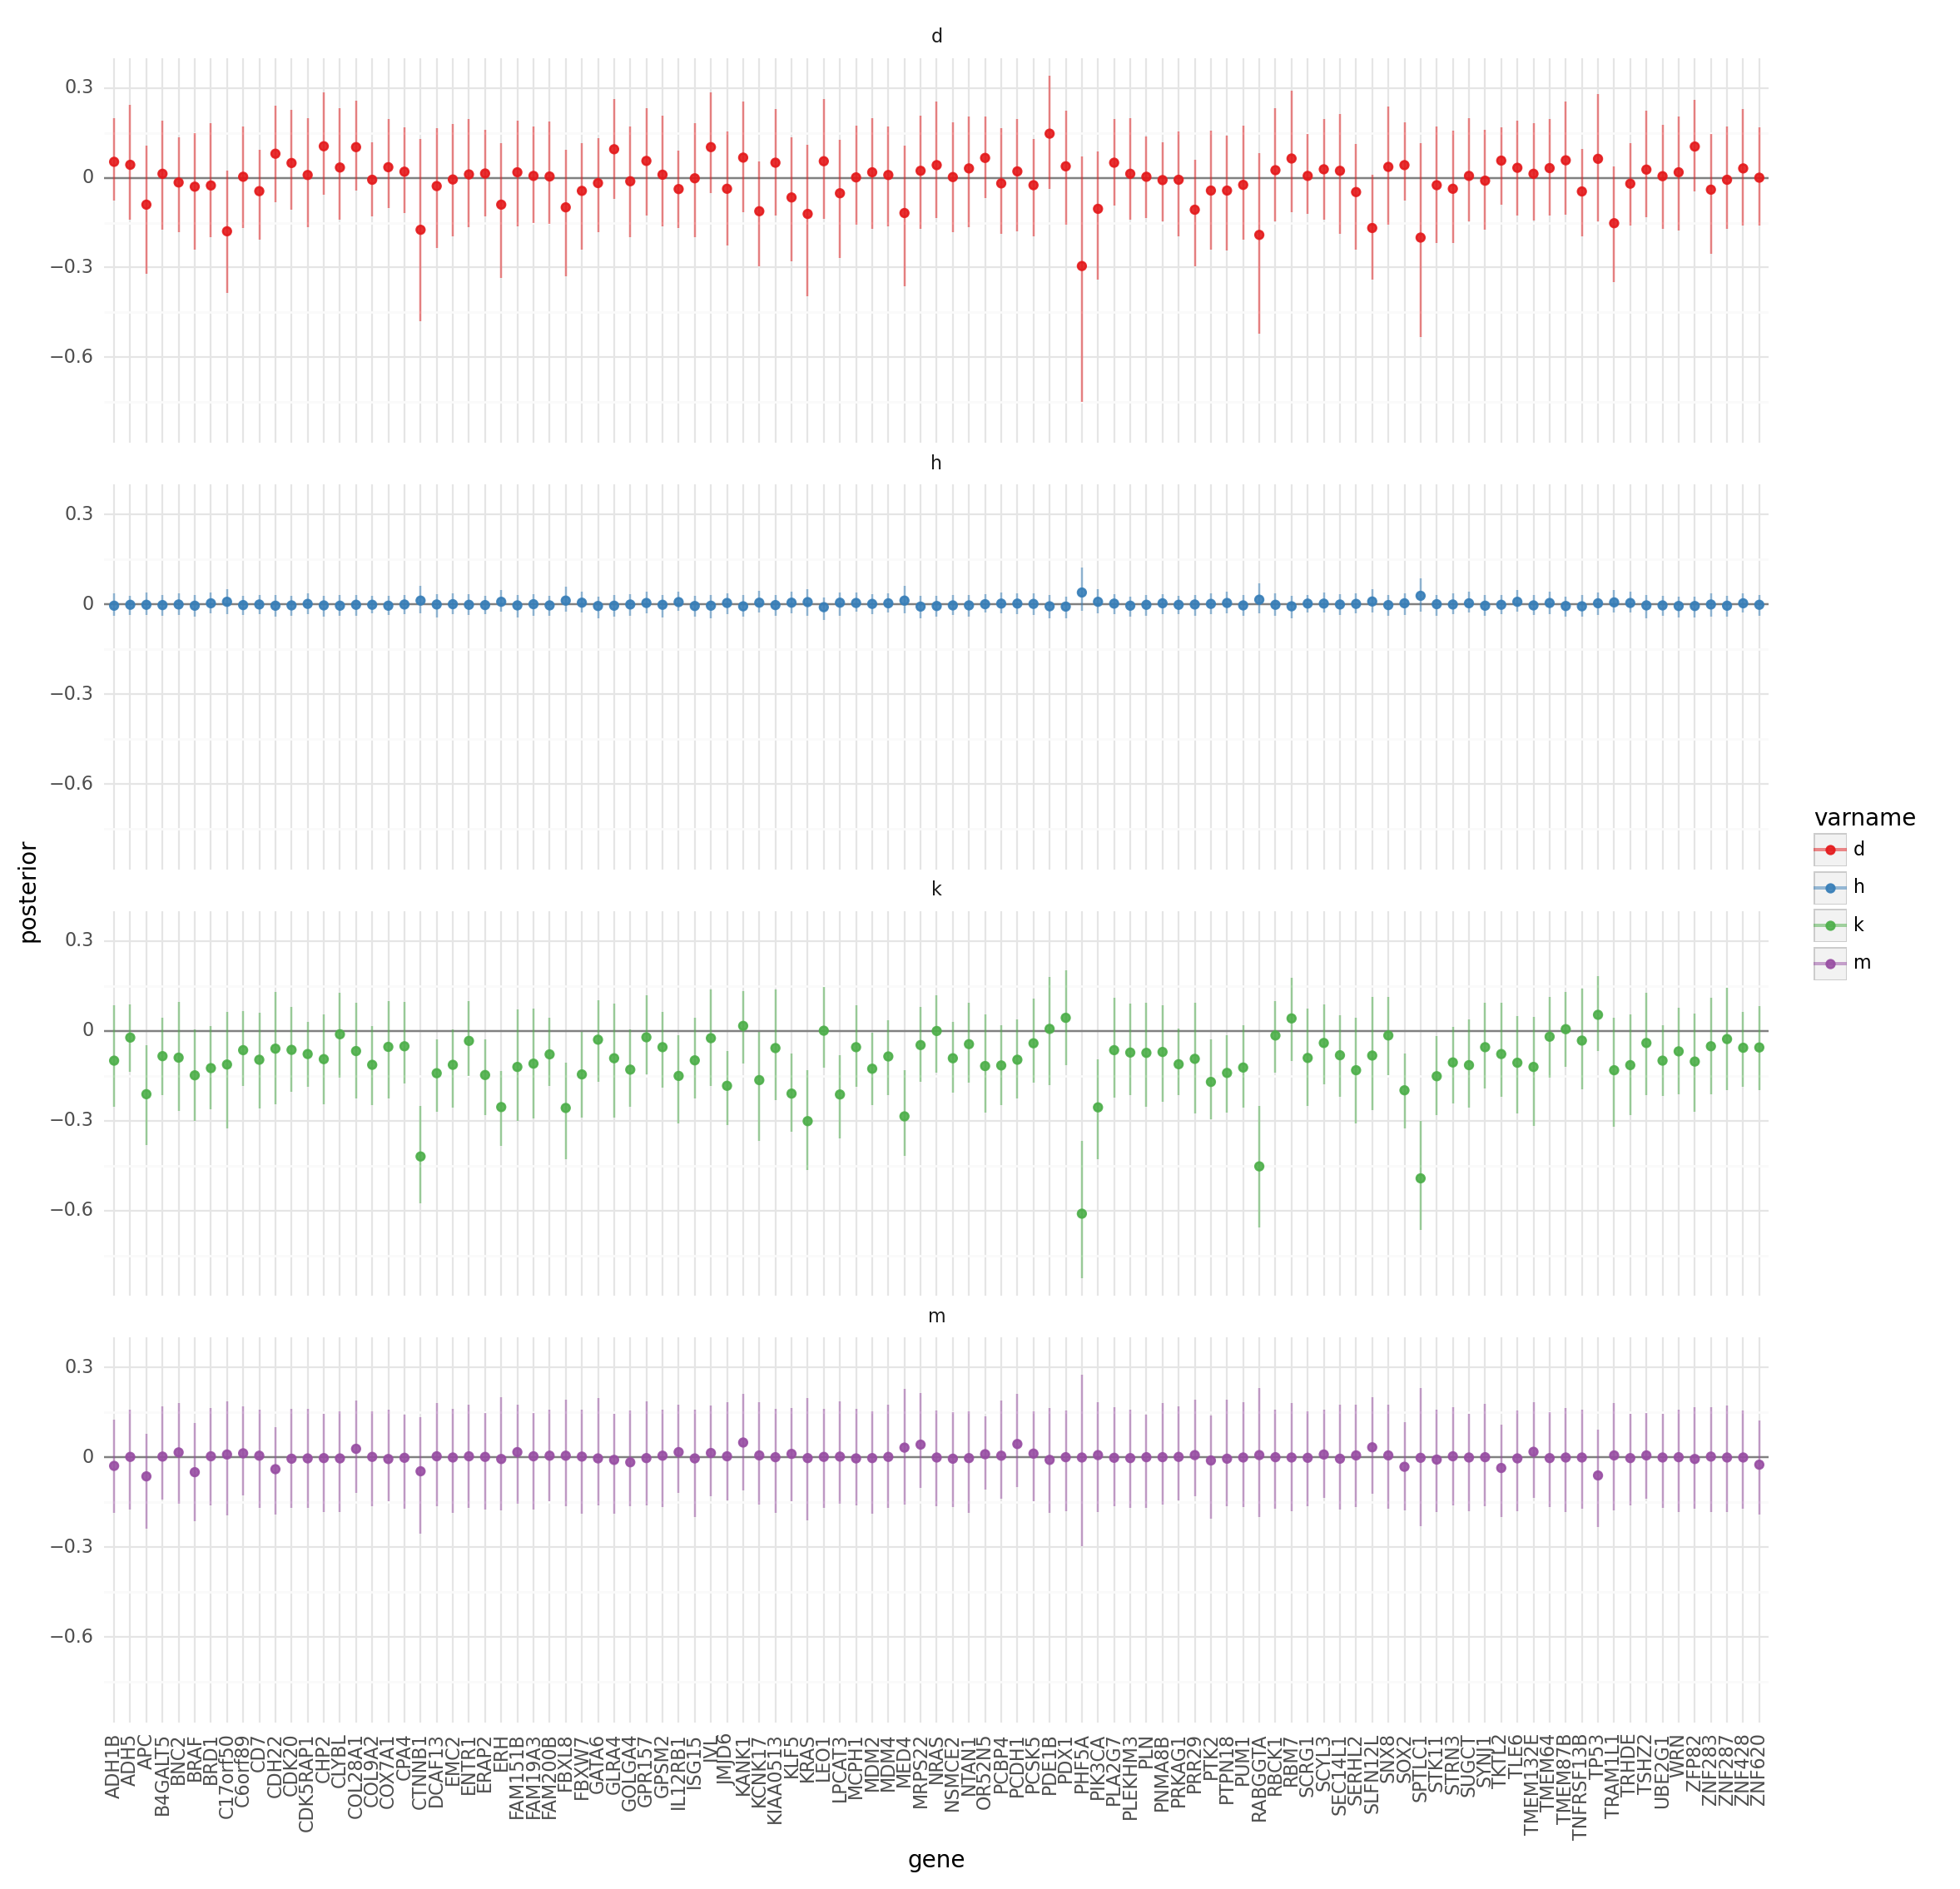

<ggplot: (358086596)>

In [115]:
(
    gg.ggplot(gene_summary, gg.aes(x="hugo_symbol", y="mean", color="varname"))
    + gg.facet_wrap("~varname", ncol=1)
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.5)
    + gg.geom_point(alpha=0.9)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=8), figure_size=(10, 10))
    + gg.labs(x="gene", y="posterior")
)

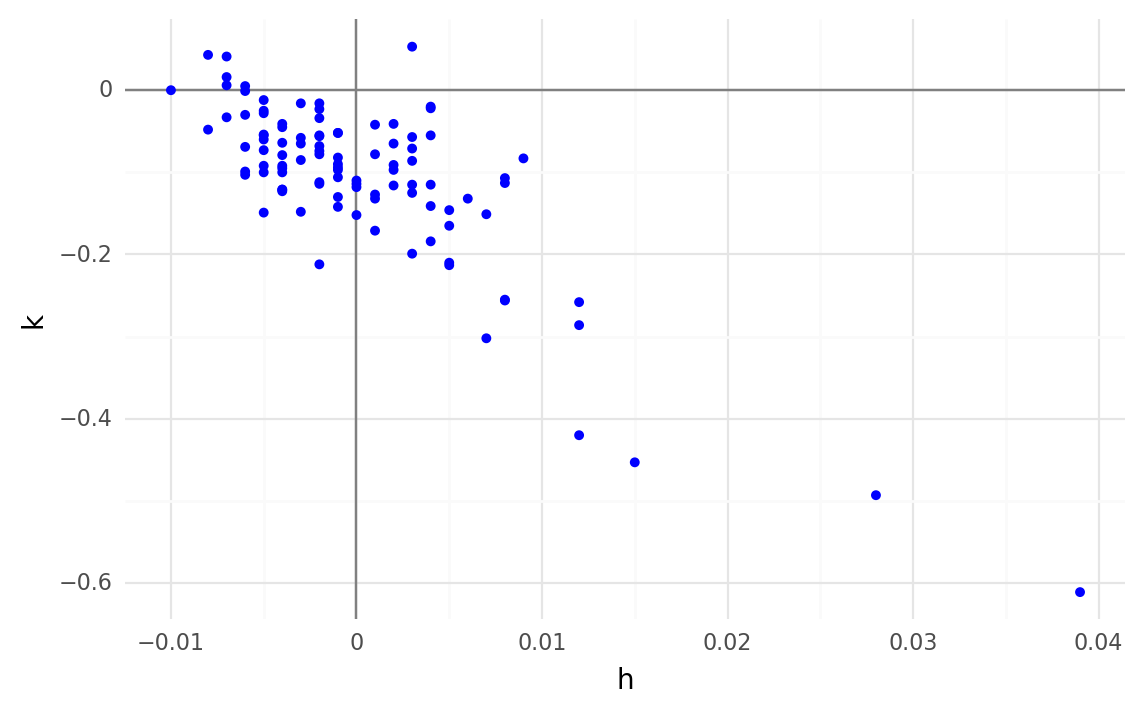

<ggplot: (360846198)>

In [116]:
plt_df = gene_summary.copy().pivot_wider(
    ["hugo_symbol"], names_from="varname", values_from="mean"
)
(
    gg.ggplot(plt_df, gg.aes(x="h", y="k"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_vline(xintercept=0, color="gray")
    + gg.geom_point(size=1, color="b")
)

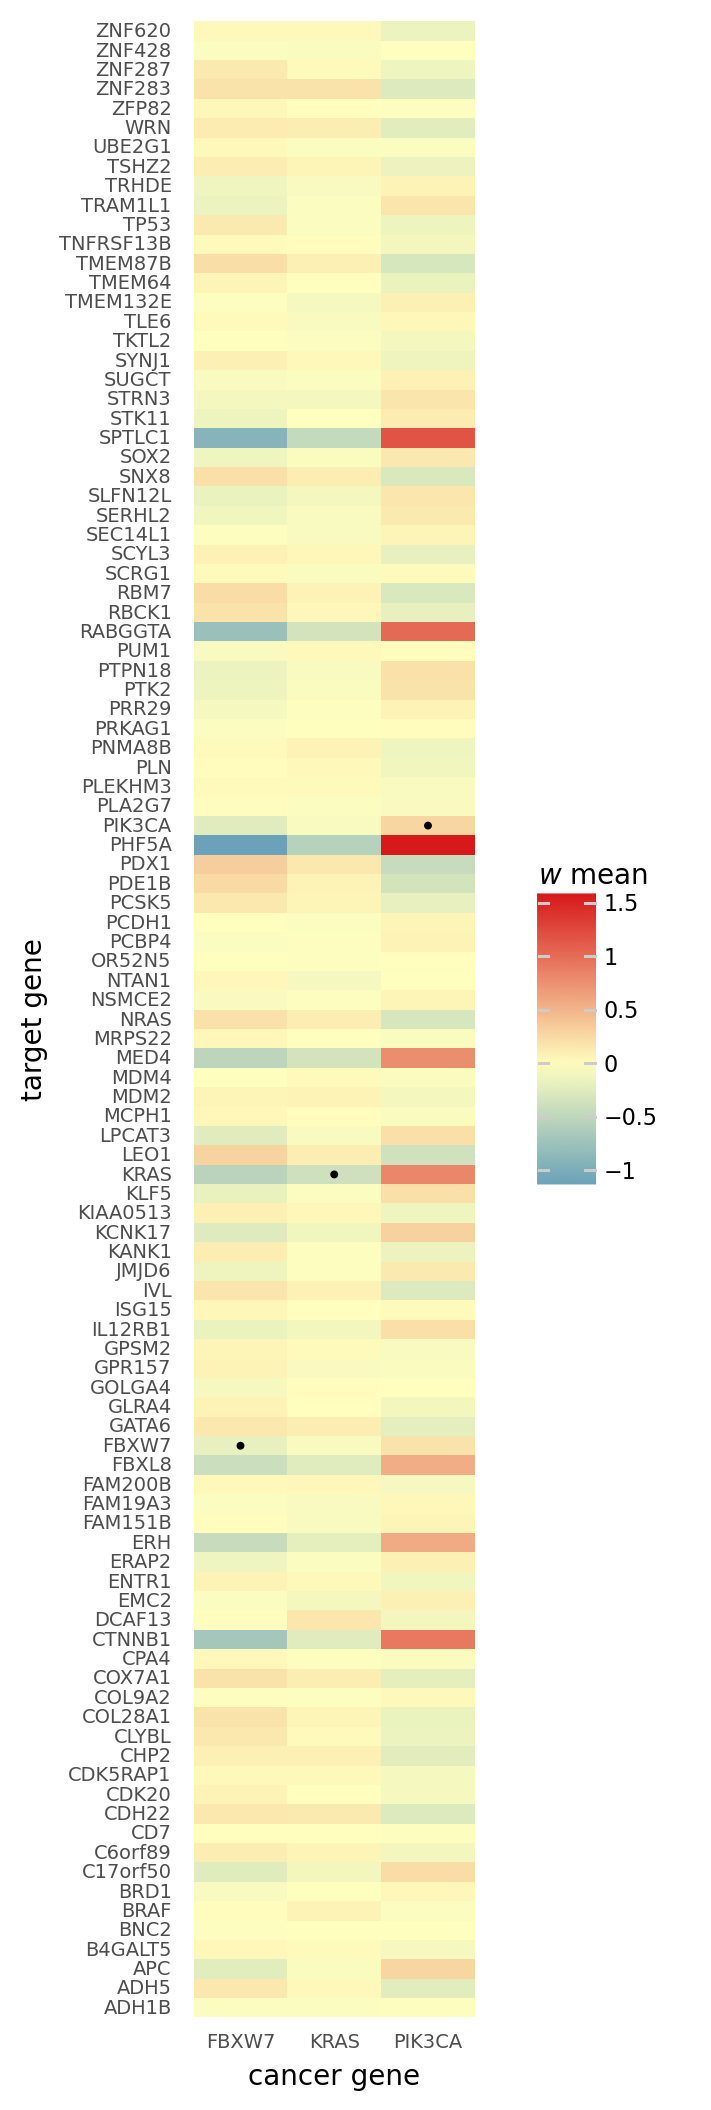

<ggplot: (360063877)>

In [117]:
w_post_summary = az.summary(trace, var_names=["w"], kind="stats").pipe(
    az_ana.extract_coords_param_names, names=["hugo_symbol", "cancer_gene"]
)
w_post_summary.head()

w_post_summary_cancer_genes = w_post_summary.copy().query("hugo_symbol == cancer_gene")

(
    gg.ggplot(w_post_summary, gg.aes(x="cancer_gene", y="hugo_symbol"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.geom_point(data=w_post_summary_cancer_genes, size=0.6)
    + scale_fill_heatmap()
    + gg.theme(
        axis_text=gg.element_text(size=7),
        panel_grid=gg.element_blank(),
        figure_size=(1.5, 10),
    )
    + gg.labs(x="cancer gene", y="target gene", fill="$w$ mean")
)

In [118]:
w_post_summary_cancer_genes

mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol cancer_gene
w[FBXW7, FBXW7]   -0.172  0.145    -0.390      0.067       FBXW7       FBXW7
w[KRAS, KRAS]     -0.353  0.150    -0.578     -0.116        KRAS        KRAS
w[PIK3CA, PIK3CA]  0.272  0.174    -0.034      0.528      PIK3CA      PIK3CA

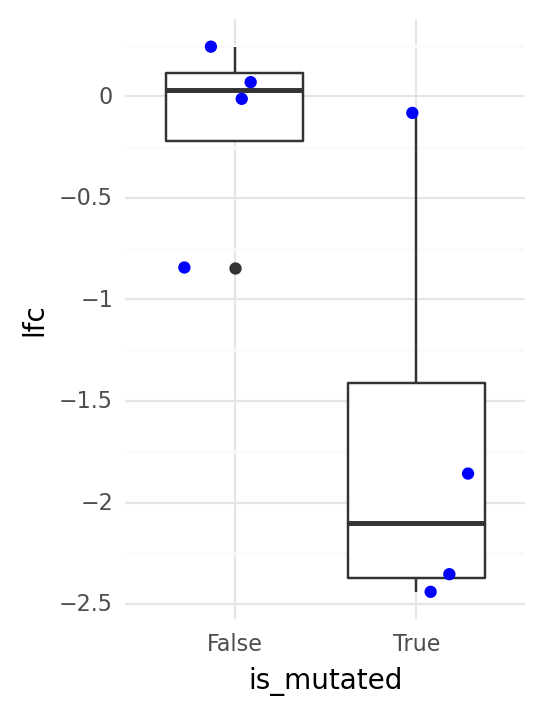

<ggplot: (359292481)>

In [121]:
(
    gg.ggplot(
        crc_crispr_data.query('hugo_symbol=="KRAS"'), gg.aes(x="is_mutated", y="lfc")
    )
    + gg.geom_boxplot()
    + gg.geom_jitter(color="b", width=0.3)
    + gg.theme(figure_size=(2, 3))
)

---

## Session information

In [122]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 97.37 minutes


In [123]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-06-02

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : Clang 12.0.1 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: per-lineage

matplotlib: 3.5.2
plotnine  : 0.8.0
numpy     : 1.22.4
pymc      : 4.0.0b6
janitor   : 0.22.0
arviz     : 0.12.1
pandas    : 1.4.2
speclet   : 0.0.9000
jaxlib    : 0.3.0
jax       : 0.2.28
aesara    : 2.6.2

